# Project 06 : Food-11 Image Classification Using Convolutional Neural Networks



Author: Anushka Gangadhar Satav

ASU ID: 1233530170 (asatav1)

Course: BMI-598 Embedded Machine Learning

## PHASE 0 : Data Preprocessing

In [1]:
!pip install kagglehub

import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import os
from tqdm import tqdm
import copy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download dataset
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")
print(f"Dataset downloaded to: {path}")

# Setup directories
data_dir = path
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'evaluation')

classes = sorted(os.listdir(train_dir))
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Count images
train_count = sum([len(os.listdir(os.path.join(train_dir, c))) for c in classes])
val_count = sum([len(os.listdir(os.path.join(val_dir, c))) for c in classes])
test_count = sum([len(os.listdir(os.path.join(test_dir, c))) for c in classes])

print(f"\nDataset splits:")
print(f"Training: {train_count}, Validation: {val_count}, Test: {test_count}")


Defaulting to user installation because normal site-packages is not writeable
Using device: cuda
Dataset downloaded to: /home/asatav1/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1
Number of classes: 11
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

Dataset splits:
Training: 9866, Validation: 3430, Test: 3347


In [2]:
class Food11Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
def calculate_dataset_stats(data_dir, sample_size=1000):
    transform_temp = transforms.Compose([
        transforms.Resize((224, 224)),  # Changed to 224
        transforms.ToTensor()
    ])
    
    temp_dataset = Food11Dataset(data_dir, transform=transform_temp)
    indices = np.random.choice(len(temp_dataset), min(sample_size, len(temp_dataset)), replace=False)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    
    print("Calculating dataset statistics (224x224)...")
    for idx in tqdm(indices):
        img, _ = temp_dataset[idx]
        for i in range(3):
            mean[i] += img[i, :, :].mean()
            std[i] += img[i, :, :].std()
    
    mean /= len(indices)
    std /= len(indices)
    
    return mean, std

train_mean, train_std = calculate_dataset_stats(train_dir, sample_size=1000)
print(f"\nDataset Statistics (Custom):")
print(f"Mean: {train_mean}")
print(f"Std: {train_std}")

# ImageNet statistics (for ShuffleNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
print(f"\nImageNet Statistics (for Phase 4):")
print(f"Mean: {IMAGENET_MEAN}")
print(f"Std: {IMAGENET_STD}")

Calculating dataset statistics (224x224)...


100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]


Dataset Statistics (Custom):
Mean: tensor([0.5562, 0.4507, 0.3431])
Std: tensor([0.2272, 0.2384, 0.2363])

ImageNet Statistics (for Phase 4):
Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


In [ ]:
print("\n" + "="*80)
print("CREATING TRANSFORMS")
print("="*80)

# For Phase 1-3: Use custom dataset statistics
train_transform_custom = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

test_transform_custom = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

# For Phase 4: Use ImageNet statistics (REQUIRED for transfer learning!)
train_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Custom transforms created (for Phase 1-3)")
print("✓ ImageNet transforms created (for Phase 4)") # Did not perform better than custom stats



CREATING TRANSFORMS
✓ Custom transforms created (for Phase 1-3)
✓ ImageNet transforms created (for Phase 4)


In [9]:
print("\n" + "="*80)
print("CREATING DATALOADERS FOR PHASE 1-3")
print("="*80)

train_dataset_custom = Food11Dataset(train_dir, transform=train_transform_custom)
val_dataset_custom = Food11Dataset(val_dir, transform=test_transform_custom)
test_dataset_custom = Food11Dataset(test_dir, transform=test_transform_custom)

batch_size = 32
train_loader_custom = DataLoader(train_dataset_custom, batch_size=batch_size, 
                                shuffle=True, num_workers=2, pin_memory=True)
val_loader_custom = DataLoader(val_dataset_custom, batch_size=batch_size, 
                              shuffle=False, num_workers=2, pin_memory=True)
test_loader_custom = DataLoader(test_dataset_custom, batch_size=batch_size, 
                               shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ Dataloaders created")
print(f"  Training batches: {len(train_loader_custom)}")
print(f"  Validation batches: {len(val_loader_custom)}")
print(f"  Test batches: {len(test_loader_custom)}")
print(f"  Image size: 224x224")


CREATING DATALOADERS FOR PHASE 1-3
✓ Dataloaders created
  Training batches: 309
  Validation batches: 108
  Test batches: 105
  Image size: 224x224


## DEFINE ALL MODEL ARCHITECTURES

In [10]:
class BasicCNN(nn.Module):
    """Phase 1: Basic CNN for 224x224"""
    def __init__(self, num_classes=11):
        super(BasicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)    # -> 32x112x112
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)   # -> 64x56x56
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # -> 128x28x28
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # -> 256x14x14
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) # -> 512x7x7
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNWithPooling(nn.Module):
    """Phase 2: CNN with Pooling"""
    def __init__(self, num_classes=11):
        super(CNNWithPooling, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNNWithDropout(nn.Module):
    """Phase 3: CNN with Pooling and Dropout"""
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

class ShuffleNetFood11(nn.Module):
    """Phase 4: ShuffleNet Transfer Learning"""
    def __init__(self, num_classes=11):
        super(ShuffleNetFood11, self).__init__()
        
        self.shufflenet = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers
        for param in self.shufflenet.parameters():
            param.requires_grad = False
        
        # Replace FC layer
        num_features = self.shufflenet.fc.in_features
        self.shufflenet.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.shufflenet(x)

print("✓ All model architectures defined")


✓ All model architectures defined


### 1. HELPER FUNCTIONS

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=20, device='cuda', scheduler=None):
    """Train model"""
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if scheduler:
            scheduler.step()
            print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'\n✓ Best validation accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, dataloader, device='cuda'):
    """Evaluate model"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy, all_preds, all_labels

def plot_training_history(train_losses, train_accs, val_losses, val_accs, title):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train', linewidth=2)
    ax1.plot(val_losses, label='Val', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(train_accs, label='Train', linewidth=2)
    ax2.plot(val_accs, label='Val', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, predictions, classes, title):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{title}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nClassification Report:")
    print(classification_report(labels, predictions, target_names=classes))

print("✓ Helper functions defined")

print("\n" + "="*80)
print("SETUP COMPLETE! Now run each phase below separately.")
print("="*80)


✓ Helper functions defined

SETUP COMPLETE! Now run each phase below separately.


# PHASE-1 Basic CNN Model Training and Evaluation


PHASE 1: BASIC CNN (224x224)
Architecture: 5 Conv layers + 2 FC layers
Normalization: Custom from dataset

Epoch 1/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.18it/s]


Train Loss: 2.1970 Acc: 0.2003


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.92it/s]


Val Loss: 2.0909 Acc: 0.2627

Epoch 2/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.14it/s]


Train Loss: 1.9999 Acc: 0.2923


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.07it/s]


Val Loss: 1.8997 Acc: 0.3283

Epoch 3/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.20it/s]


Train Loss: 1.8001 Acc: 0.3594


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.71it/s]


Val Loss: 1.7899 Acc: 0.3714

Epoch 4/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.07it/s]


Train Loss: 1.6667 Acc: 0.4140


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.71it/s]


Val Loss: 1.6430 Acc: 0.4155

Epoch 5/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.02it/s]


Train Loss: 1.5386 Acc: 0.4631


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.59it/s]


Val Loss: 1.5523 Acc: 0.4644

Epoch 6/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.83it/s]


Train Loss: 1.4154 Acc: 0.5083


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.79it/s]


Val Loss: 1.5237 Acc: 0.4907

Epoch 7/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.03it/s]


Train Loss: 1.3170 Acc: 0.5425


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.76it/s]


Val Loss: 1.4904 Acc: 0.4761

Epoch 8/8
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.81it/s]


Train Loss: 1.2077 Acc: 0.5832


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.66it/s]


Val Loss: 1.5080 Acc: 0.5087

✓ Best validation accuracy: 0.5087


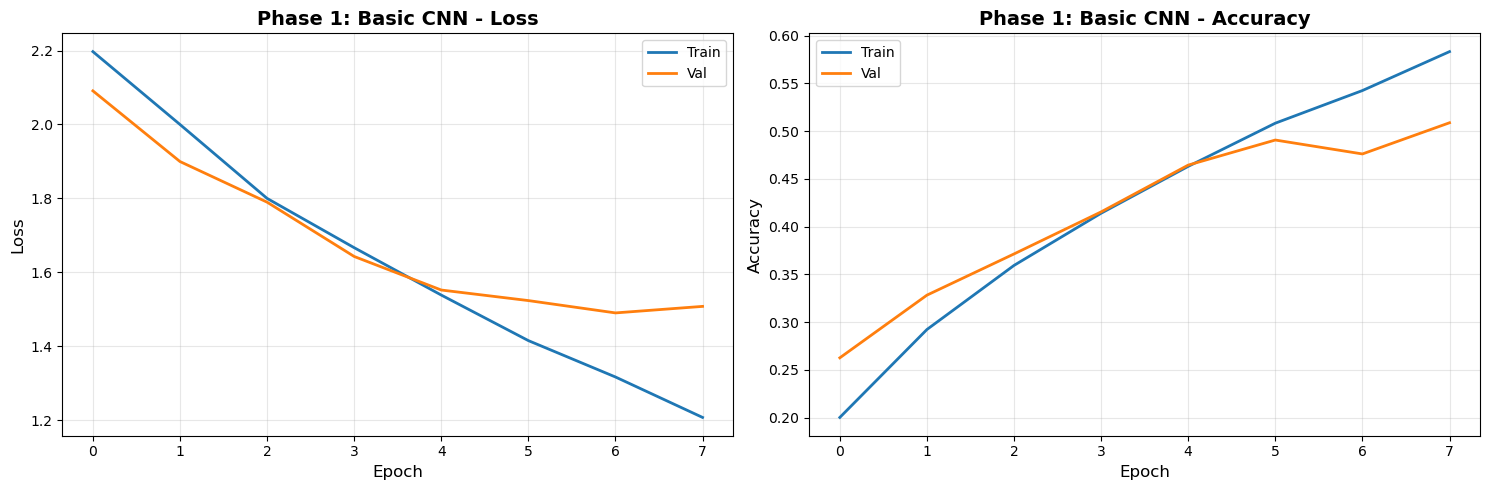

Evaluating: 100%|██████████| 105/105 [00:07<00:00, 14.17it/s]



PHASE 1 RESULTS
Test Accuracy: 0.5267 (52.67%)


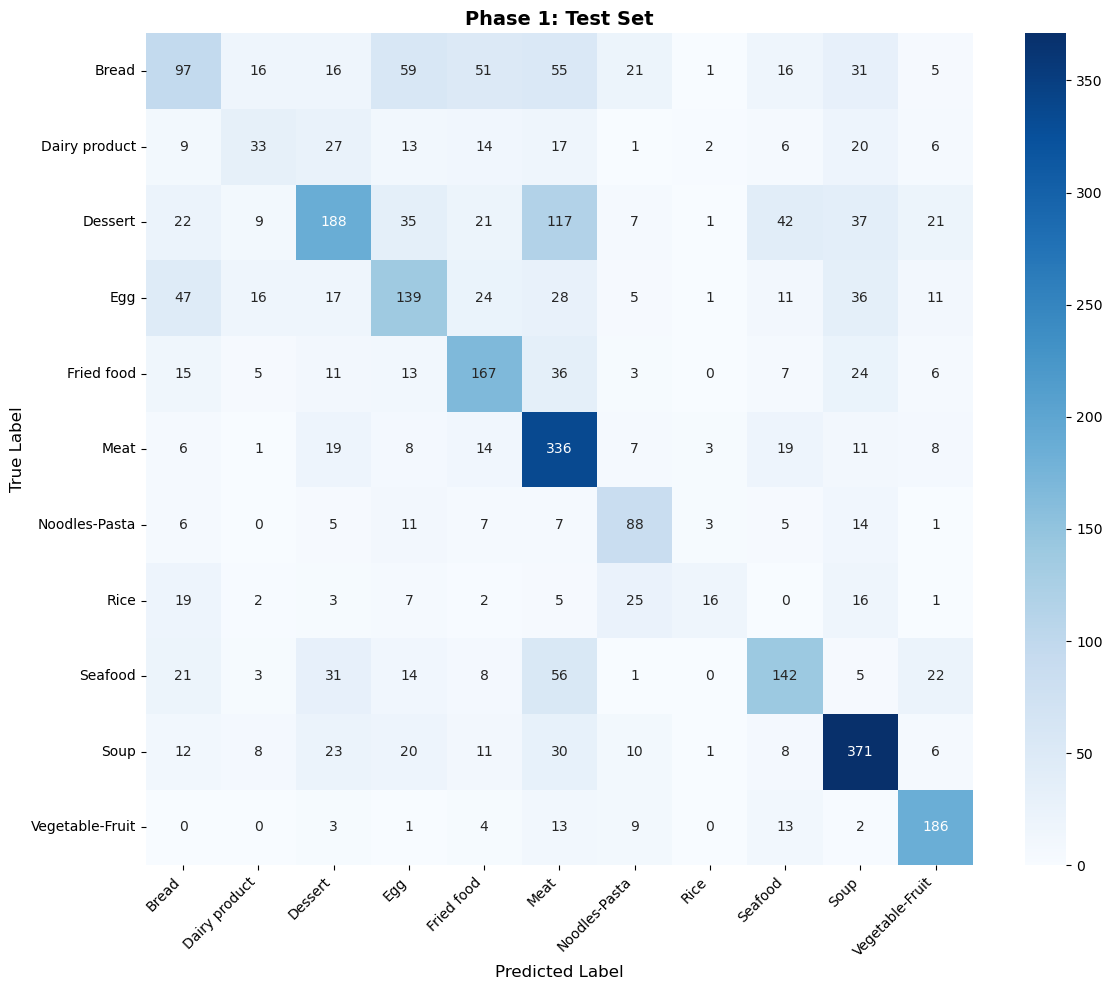


Classification Report:
                 precision    recall  f1-score   support

          Bread       0.38      0.26      0.31       368
  Dairy product       0.35      0.22      0.27       148
        Dessert       0.55      0.38      0.45       500
            Egg       0.43      0.41      0.42       335
     Fried food       0.52      0.58      0.55       287
           Meat       0.48      0.78      0.59       432
  Noodles-Pasta       0.50      0.60      0.54       147
           Rice       0.57      0.17      0.26        96
        Seafood       0.53      0.47      0.50       303
           Soup       0.65      0.74      0.70       500
Vegetable-Fruit       0.68      0.81      0.74       231

       accuracy                           0.53      3347
      macro avg       0.51      0.49      0.48      3347
   weighted avg       0.52      0.53      0.51      3347

✓ Model saved to saved_models/phase1_basic_cnn.pth


In [13]:
# FOR PHASE 1

print("\n" + "="*80)
print("PHASE 1: BASIC CNN (224x224)")
print("Architecture: 5 Conv layers + 2 FC layers")
print("Normalization: Custom from dataset")
print("="*80)

model_phase1 = BasicCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_phase1.parameters(), lr=0.001)

model_phase1, train_losses_p1, train_accs_p1, val_losses_p1, val_accs_p1 = train_model(
    model_phase1, train_loader_custom, val_loader_custom, criterion, optimizer,
    num_epochs=8, device=device
)

# Plot results
plot_training_history(train_losses_p1, train_accs_p1, val_losses_p1, val_accs_p1, 
                      "Phase 1: Basic CNN")

# Evaluate
test_acc_p1, test_preds_p1, test_labels_p1 = evaluate_model(model_phase1, test_loader_custom, device)
print(f"\n{'='*60}")
print(f"PHASE 1 RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc_p1:.4f} ({test_acc_p1*100:.2f}%)")
print(f"{'='*60}")

plot_confusion_matrix(test_labels_p1, test_preds_p1, classes, "Phase 1: Test Set")

# Save model
os.makedirs('saved_models', exist_ok=True)
torch.save(model_phase1.state_dict(), 'saved_models/phase1_basic_cnn.pth')
print("✓ Model saved to saved_models/phase1_basic_cnn.pth")


# PHASE-2 Basic CNN Model with Pooling - Training and Evaluation


PHASE 2: CNN WITH POOLING (224x224)
Architecture: 4 Conv + 4 MaxPool + 3 FC layers
Improvement: Pooling for better feature extraction

Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.10it/s]


Train Loss: 2.0985 Acc: 0.2521


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.03it/s]


Val Loss: 1.9113 Acc: 0.3431

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.00it/s]


Train Loss: 1.8780 Acc: 0.3401


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.85it/s]


Val Loss: 1.7400 Acc: 0.3901

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.08it/s]


Train Loss: 1.6997 Acc: 0.4069


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.90it/s]


Val Loss: 1.6735 Acc: 0.4105

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.86it/s]


Train Loss: 1.5537 Acc: 0.4600


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.60it/s]


Val Loss: 1.4716 Acc: 0.4889

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.00it/s]


Train Loss: 1.4129 Acc: 0.5092


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.89it/s]


Val Loss: 1.5027 Acc: 0.4921

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.84it/s]


Train Loss: 1.2891 Acc: 0.5539


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.84it/s]


Val Loss: 1.4167 Acc: 0.5105

Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.88it/s]


Train Loss: 1.1827 Acc: 0.5913


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.85it/s]


Val Loss: 1.3513 Acc: 0.5417

Epoch 8/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.04it/s]


Train Loss: 1.0657 Acc: 0.6297


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.96it/s]


Val Loss: 1.3260 Acc: 0.5636

Epoch 9/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.92it/s]


Train Loss: 0.9623 Acc: 0.6734


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.80it/s]


Val Loss: 1.4327 Acc: 0.5458

Epoch 10/10
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.83it/s]


Train Loss: 0.8633 Acc: 0.7012


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.89it/s]


Val Loss: 1.4025 Acc: 0.5528

✓ Best validation accuracy: 0.5636


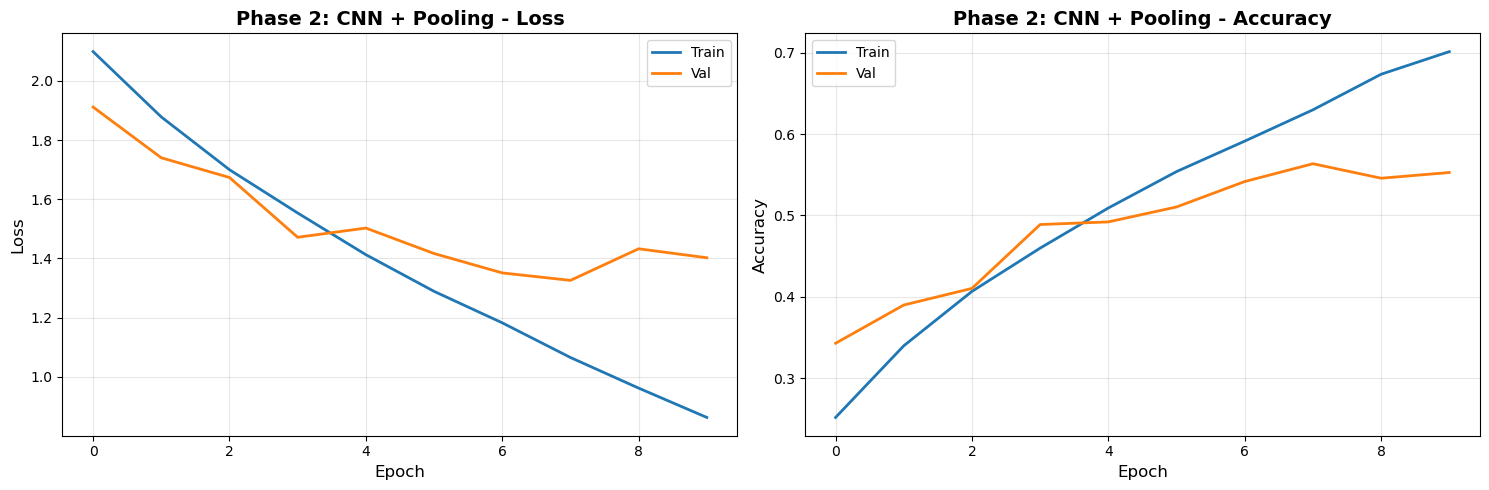

Evaluating: 100%|██████████| 105/105 [00:07<00:00, 14.46it/s]



PHASE 2 RESULTS
Test Accuracy: 0.5808 (58.08%)
Improvement from Phase 1: +5.41%


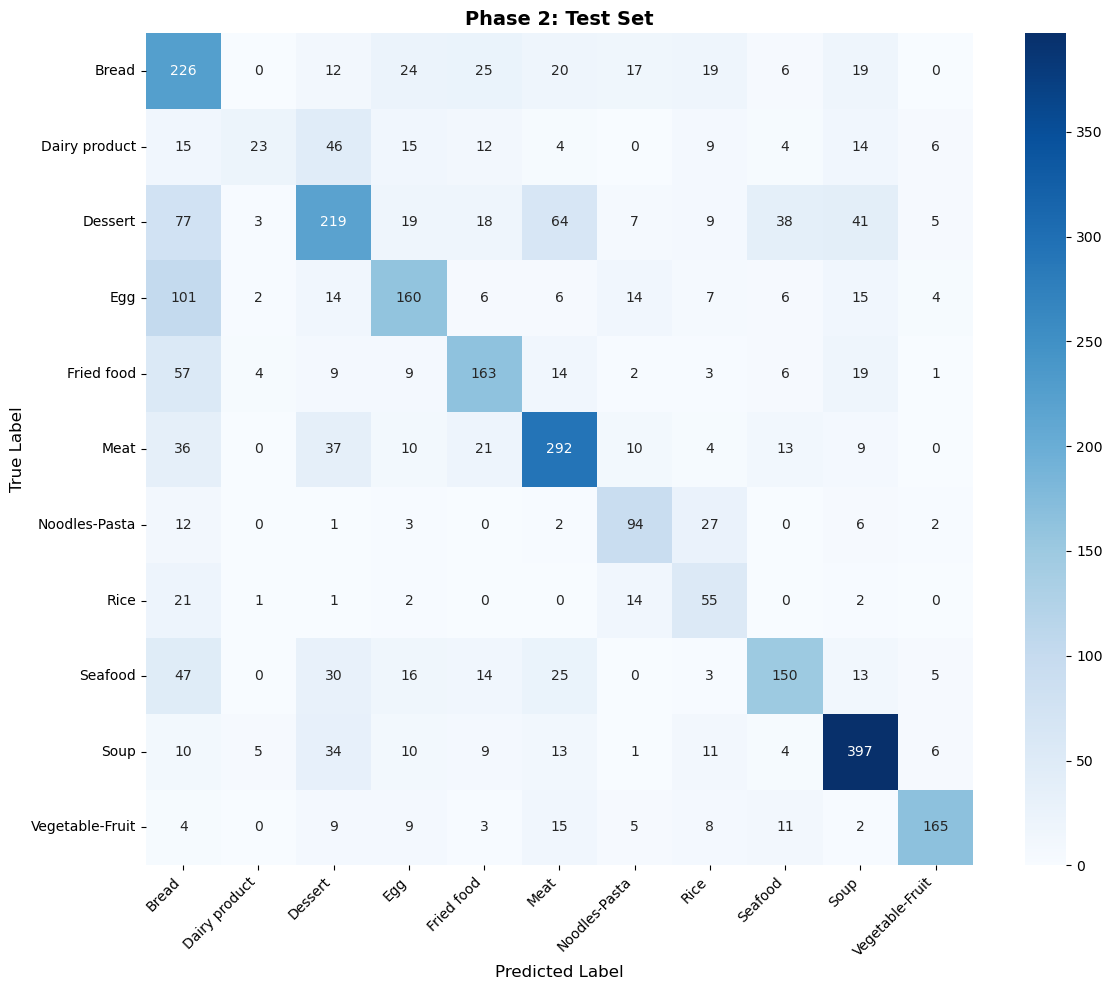


Classification Report:
                 precision    recall  f1-score   support

          Bread       0.37      0.61      0.46       368
  Dairy product       0.61      0.16      0.25       148
        Dessert       0.53      0.44      0.48       500
            Egg       0.58      0.48      0.52       335
     Fried food       0.60      0.57      0.58       287
           Meat       0.64      0.68      0.66       432
  Noodles-Pasta       0.57      0.64      0.60       147
           Rice       0.35      0.57      0.44        96
        Seafood       0.63      0.50      0.55       303
           Soup       0.74      0.79      0.77       500
Vegetable-Fruit       0.85      0.71      0.78       231

       accuracy                           0.58      3347
      macro avg       0.59      0.56      0.55      3347
   weighted avg       0.60      0.58      0.58      3347

✓ Model saved to saved_models/phase2_cnn_pooling.pth


In [14]:
# FOR PHASE 2

print("\n" + "="*80)
print("PHASE 2: CNN WITH POOLING (224x224)")
print("Architecture: 4 Conv + 4 MaxPool + 3 FC layers")
print("Improvement: Pooling for better feature extraction")
print("="*80)

model_phase2 = CNNWithPooling(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_phase2.parameters(), lr=0.001)

model_phase2, train_losses_p2, train_accs_p2, val_losses_p2, val_accs_p2 = train_model(
    model_phase2, train_loader_custom, val_loader_custom, criterion, optimizer,
    num_epochs=10, device=device
)

# Plot results
plot_training_history(train_losses_p2, train_accs_p2, val_losses_p2, val_accs_p2, 
                      "Phase 2: CNN + Pooling")

# Evaluate
test_acc_p2, test_preds_p2, test_labels_p2 = evaluate_model(model_phase2, test_loader_custom, device)
print(f"\n{'='*60}")
print(f"PHASE 2 RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc_p2:.4f} ({test_acc_p2*100:.2f}%)")
print(f"Improvement from Phase 1: {(test_acc_p2-test_acc_p1)*100:+.2f}%")
print(f"{'='*60}")

plot_confusion_matrix(test_labels_p2, test_preds_p2, classes, "Phase 2: Test Set")

# Save model
torch.save(model_phase2.state_dict(), 'saved_models/phase2_cnn_pooling.pth')
print("✓ Model saved to saved_models/phase2_cnn_pooling.pth")


# PHASE-3 CNN Model with Pooling and Dropout - Training and Evaluation


PHASE 3: CNN WITH DROPOUT (224x224)
Architecture: Same as Phase 2 + Dropout (0.5)
Improvement: Reduce overfitting with dropout

Epoch 1/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.05it/s]


Train Loss: 2.2132 Acc: 0.2070


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.68it/s]


Val Loss: 1.9970 Acc: 0.2831

Epoch 2/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.87it/s]


Train Loss: 2.0282 Acc: 0.2889


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.87it/s]


Val Loss: 1.9085 Acc: 0.3414

Epoch 3/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.89it/s]


Train Loss: 1.9122 Acc: 0.3454


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.93it/s]


Val Loss: 1.7430 Acc: 0.3959

Epoch 4/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.93it/s]


Train Loss: 1.8017 Acc: 0.3875


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.74it/s]


Val Loss: 1.7305 Acc: 0.4003

Epoch 5/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.85it/s]


Train Loss: 1.6836 Acc: 0.4290


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.75it/s]


Val Loss: 1.6939 Acc: 0.4204

Epoch 6/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.96it/s]


Train Loss: 1.6276 Acc: 0.4486


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.76it/s]


Val Loss: 1.4888 Acc: 0.4880

Epoch 7/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.00it/s]


Train Loss: 1.5429 Acc: 0.4769


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.80it/s]


Val Loss: 1.3996 Acc: 0.5230

Epoch 8/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.94it/s]


Train Loss: 1.4581 Acc: 0.5039


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.66it/s]


Val Loss: 1.4438 Acc: 0.5248

Epoch 9/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.70it/s]


Train Loss: 1.4110 Acc: 0.5250


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.74it/s]


Val Loss: 1.3419 Acc: 0.5475

Epoch 10/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.00it/s]


Train Loss: 1.3432 Acc: 0.5490


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.64it/s]


Val Loss: 1.3208 Acc: 0.5402

Epoch 11/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.05it/s]


Train Loss: 1.2870 Acc: 0.5663


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.64it/s]


Val Loss: 1.3390 Acc: 0.5504

Epoch 12/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.83it/s]


Train Loss: 1.2356 Acc: 0.5768


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.91it/s]


Val Loss: 1.3156 Acc: 0.5554

Epoch 13/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.62it/s]


Train Loss: 1.1985 Acc: 0.5916


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.65it/s]


Val Loss: 1.3582 Acc: 0.5478

Epoch 14/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.73it/s]


Train Loss: 1.1807 Acc: 0.6042


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.85it/s]


Val Loss: 1.3333 Acc: 0.5528

Epoch 15/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.12it/s]


Train Loss: 1.1210 Acc: 0.6211


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.89it/s]


Val Loss: 1.3135 Acc: 0.5717

Epoch 16/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.99it/s]


Train Loss: 1.0795 Acc: 0.6393


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.96it/s]


Val Loss: 1.2802 Acc: 0.5810

Epoch 17/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.93it/s]


Train Loss: 1.0519 Acc: 0.6461


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.90it/s]


Val Loss: 1.2601 Acc: 0.5939

Epoch 18/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.94it/s]


Train Loss: 0.9990 Acc: 0.6674


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.03it/s]


Val Loss: 1.2334 Acc: 0.6041

Epoch 19/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.84it/s]


Train Loss: 0.9852 Acc: 0.6741


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.00it/s]


Val Loss: 1.2446 Acc: 0.5910

Epoch 20/20
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.17it/s]


Train Loss: 0.9548 Acc: 0.6859


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.72it/s]


Val Loss: 1.2742 Acc: 0.5901

✓ Best validation accuracy: 0.6041


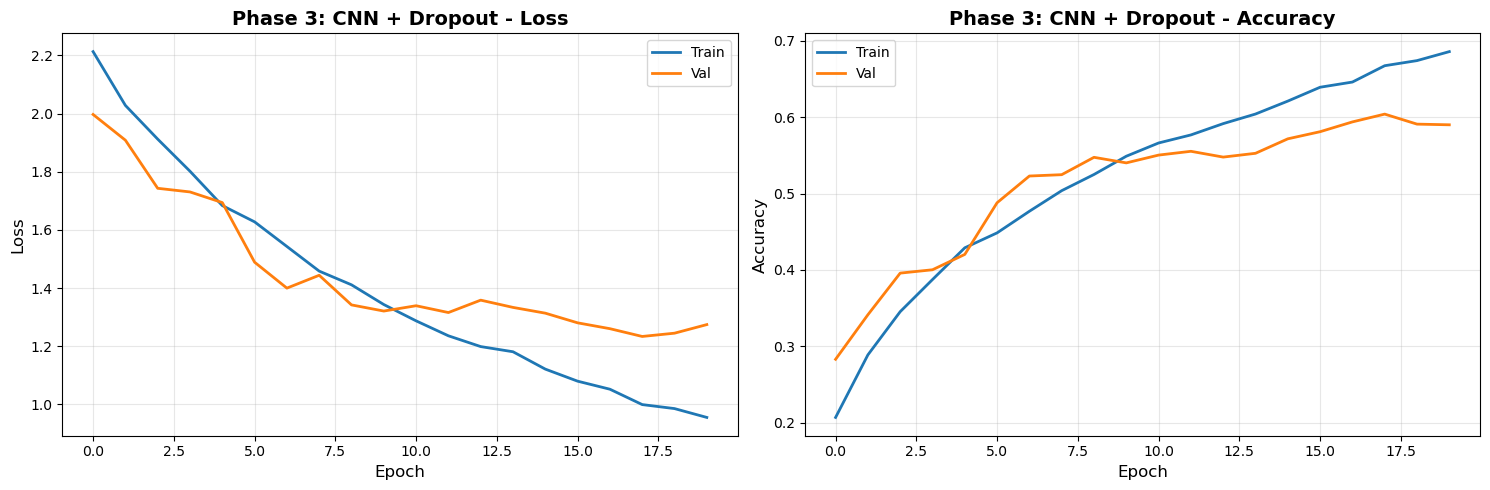

Evaluating: 100%|██████████| 105/105 [00:07<00:00, 13.54it/s]



PHASE 3 RESULTS
Test Accuracy: 0.6125 (61.25%)
Improvement from Phase 2: +3.17%

Overfitting Analysis (Train-Val Gap):
  Phase 2: 0.1484
  Phase 3: 0.0958
  Reduction: 5.26%


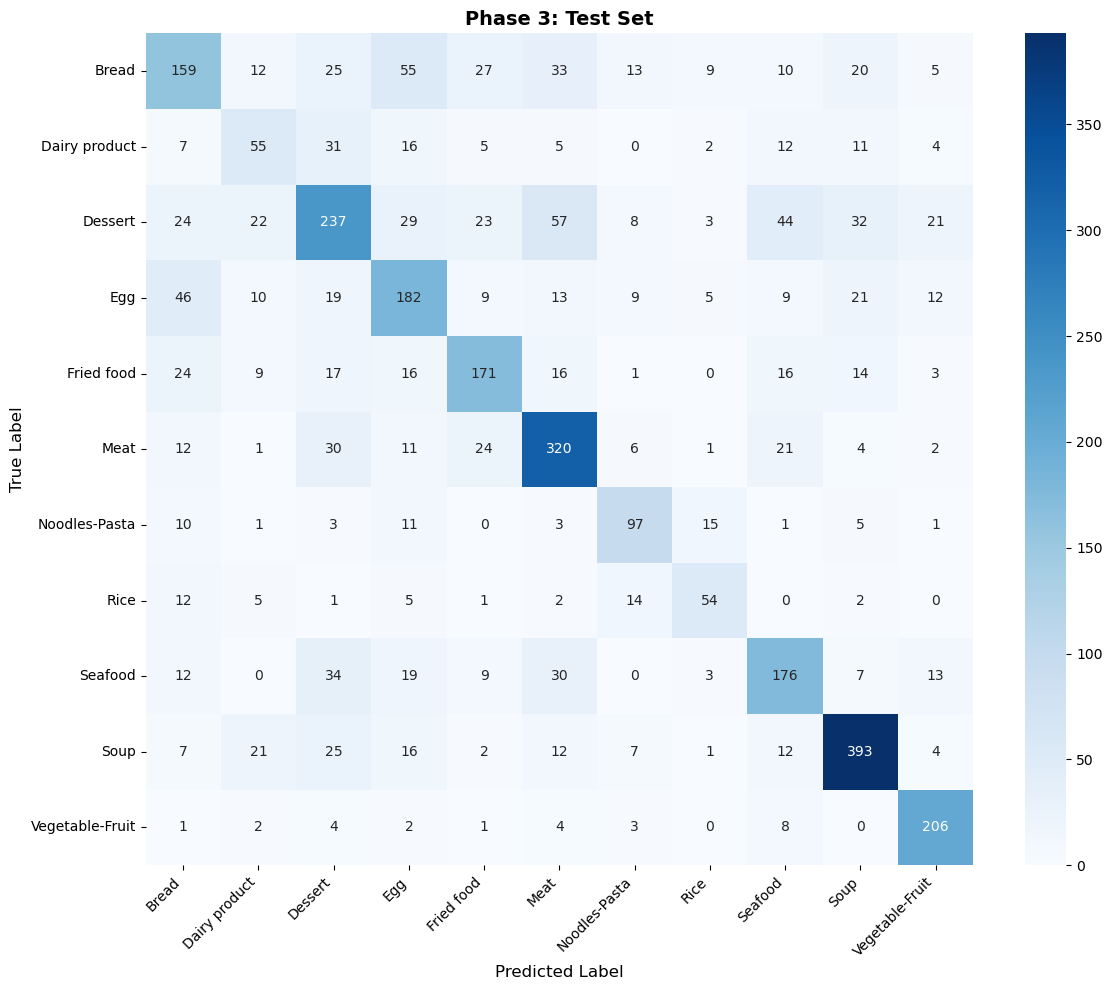


Classification Report:
                 precision    recall  f1-score   support

          Bread       0.51      0.43      0.47       368
  Dairy product       0.40      0.37      0.38       148
        Dessert       0.56      0.47      0.51       500
            Egg       0.50      0.54      0.52       335
     Fried food       0.63      0.60      0.61       287
           Meat       0.65      0.74      0.69       432
  Noodles-Pasta       0.61      0.66      0.64       147
           Rice       0.58      0.56      0.57        96
        Seafood       0.57      0.58      0.58       303
           Soup       0.77      0.79      0.78       500
Vegetable-Fruit       0.76      0.89      0.82       231

       accuracy                           0.61      3347
      macro avg       0.59      0.60      0.60      3347
   weighted avg       0.61      0.61      0.61      3347

✓ Model saved to saved_models/phase3_cnn_dropout.pth


In [15]:
# FOR PHASE 3

print("\n" + "="*80)
print("PHASE 3: CNN WITH DROPOUT (224x224)")
print("Architecture: Same as Phase 2 + Dropout (0.5)")
print("Improvement: Reduce overfitting with dropout")
print("="*80)

model_phase3 = CNNWithDropout(num_classes=num_classes, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_phase3.parameters(), lr=0.001)

model_phase3, train_losses_p3, train_accs_p3, val_losses_p3, val_accs_p3 = train_model(
    model_phase3, train_loader_custom, val_loader_custom, criterion, optimizer,
    num_epochs=20, device=device
)

# Plot results
plot_training_history(train_losses_p3, train_accs_p3, val_losses_p3, val_accs_p3, 
                      "Phase 3: CNN + Dropout")

# Evaluate
test_acc_p3, test_preds_p3, test_labels_p3 = evaluate_model(model_phase3, test_loader_custom, device)
print(f"\n{'='*60}")
print(f"PHASE 3 RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc_p3:.4f} ({test_acc_p3*100:.2f}%)")
print(f"Improvement from Phase 2: {(test_acc_p3-test_acc_p2)*100:+.2f}%")

# Overfitting analysis
gap_p2 = train_accs_p2[-1] - val_accs_p2[-1]
gap_p3 = train_accs_p3[-1] - val_accs_p3[-1]
print(f"\nOverfitting Analysis (Train-Val Gap):")
print(f"  Phase 2: {gap_p2:.4f}")
print(f"  Phase 3: {gap_p3:.4f}")
print(f"  Reduction: {(gap_p2-gap_p3)*100:.2f}%")
print(f"{'='*60}")

plot_confusion_matrix(test_labels_p3, test_preds_p3, classes, "Phase 3: Test Set")

# Save model
torch.save(model_phase3.state_dict(), 'saved_models/phase3_cnn_dropout.pth')
print("✓ Model saved to saved_models/phase3_cnn_dropout.pth")


# PHASE-4 ShuffleNet Transfer Learning


PHASE 4: SHUFFLENET TRANSFER LEARNING (224x224)
CRITICAL: Creating NEW dataloaders with ImageNet normalization!
Architecture: Pre-trained ShuffleNet (frozen) + new FC layer
Expected: 80%+ accuracy
✓ ImageNet-normalized dataloaders created

Epoch 1/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.38it/s]


Train Loss: 2.1353 Acc: 0.3316


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.27it/s]


Val Loss: 1.9566 Acc: 0.4583

Epoch 2/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.86it/s]


Train Loss: 1.8527 Acc: 0.4962


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.25it/s]


Val Loss: 1.7074 Acc: 0.5569

Epoch 3/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.05it/s]


Train Loss: 1.6459 Acc: 0.5797


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.24it/s]


Val Loss: 1.5371 Acc: 0.6327

Epoch 4/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.87it/s]


Train Loss: 1.4974 Acc: 0.6190


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.32it/s]


Val Loss: 1.4116 Acc: 0.6379

Epoch 5/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.89it/s]


Train Loss: 1.3857 Acc: 0.6379


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.76it/s]


Val Loss: 1.2987 Acc: 0.6551

Epoch 6/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.29it/s]


Train Loss: 1.2933 Acc: 0.6564


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.27it/s]


Val Loss: 1.2366 Acc: 0.6659

Epoch 7/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.39it/s]


Train Loss: 1.2227 Acc: 0.6713


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.98it/s]


Val Loss: 1.1553 Acc: 0.6892

Epoch 8/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.85it/s]


Train Loss: 1.1670 Acc: 0.6800


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.26it/s]


Val Loss: 1.1010 Acc: 0.7026

Epoch 9/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.21it/s]


Train Loss: 1.1166 Acc: 0.6918


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.24it/s]


Val Loss: 1.0692 Acc: 0.6971

Epoch 10/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.30it/s]


Train Loss: 1.0792 Acc: 0.6948


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.36it/s]


Val Loss: 1.0414 Acc: 0.6985

Epoch 11/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.38it/s]


Train Loss: 1.0479 Acc: 0.7020


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.21it/s]


Val Loss: 1.0006 Acc: 0.7131

Epoch 12/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.84it/s]


Train Loss: 1.0175 Acc: 0.7075


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.43it/s]


Val Loss: 0.9658 Acc: 0.7175

Epoch 13/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.05it/s]


Train Loss: 0.9931 Acc: 0.7124


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.20it/s]


Val Loss: 0.9585 Acc: 0.7143

Epoch 14/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.07it/s]


Train Loss: 0.9762 Acc: 0.7114


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.99it/s]


Val Loss: 0.9317 Acc: 0.7306

Epoch 15/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.94it/s]


Train Loss: 0.9444 Acc: 0.7216


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.69it/s]


Val Loss: 0.8948 Acc: 0.7373

Epoch 16/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.15it/s]


Train Loss: 0.9303 Acc: 0.7246


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.33it/s]


Val Loss: 0.8957 Acc: 0.7306

Epoch 17/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.23it/s]


Train Loss: 0.9112 Acc: 0.7312


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.15it/s]


Val Loss: 0.8706 Acc: 0.7405

Epoch 18/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.90it/s]


Train Loss: 0.8954 Acc: 0.7327


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.84it/s]


Val Loss: 0.8556 Acc: 0.7490

Epoch 19/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.42it/s]


Train Loss: 0.8815 Acc: 0.7320


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.23it/s]


Val Loss: 0.8502 Acc: 0.7423

Epoch 20/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.80it/s]


Train Loss: 0.8651 Acc: 0.7390


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.21it/s]


Val Loss: 0.8543 Acc: 0.7399

Epoch 21/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.15it/s]


Train Loss: 0.8584 Acc: 0.7369


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.94it/s]


Val Loss: 0.8312 Acc: 0.7513

Epoch 22/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.19it/s]


Train Loss: 0.8487 Acc: 0.7466


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.58it/s]


Val Loss: 0.8144 Acc: 0.7574

Epoch 23/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.16it/s]


Train Loss: 0.8409 Acc: 0.7447


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.17it/s]


Val Loss: 0.7899 Acc: 0.7650

Epoch 24/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.00it/s]


Train Loss: 0.8289 Acc: 0.7462


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.21it/s]


Val Loss: 0.8097 Acc: 0.7563

Epoch 25/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.19it/s]


Train Loss: 0.8286 Acc: 0.7451


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.90it/s]


Val Loss: 0.7858 Acc: 0.7673

Epoch 26/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.30it/s]


Train Loss: 0.8108 Acc: 0.7468


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.28it/s]


Val Loss: 0.7761 Acc: 0.7685

Epoch 27/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.16it/s]


Train Loss: 0.8102 Acc: 0.7521


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.88it/s]


Val Loss: 0.7636 Acc: 0.7714

Epoch 28/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.40it/s]


Train Loss: 0.7957 Acc: 0.7527


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.28it/s]


Val Loss: 0.7698 Acc: 0.7703

Epoch 29/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.40it/s]


Train Loss: 0.7826 Acc: 0.7598


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.23it/s]


Val Loss: 0.7588 Acc: 0.7717

Epoch 30/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.03it/s]


Train Loss: 0.7765 Acc: 0.7626


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.77it/s]


Val Loss: 0.7497 Acc: 0.7773

Epoch 31/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.04it/s]


Train Loss: 0.7807 Acc: 0.7593


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.32it/s]


Val Loss: 0.7367 Acc: 0.7802

Epoch 32/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.38it/s]


Train Loss: 0.7724 Acc: 0.7568


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.89it/s]


Val Loss: 0.7517 Acc: 0.7717

Epoch 33/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.09it/s]


Train Loss: 0.7612 Acc: 0.7705


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.90it/s]


Val Loss: 0.7398 Acc: 0.7781

Epoch 34/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.94it/s]


Train Loss: 0.7623 Acc: 0.7600


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.86it/s]


Val Loss: 0.7293 Acc: 0.7802

Epoch 35/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.13it/s]


Train Loss: 0.7592 Acc: 0.7626


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.84it/s]


Val Loss: 0.7159 Acc: 0.7805

Epoch 36/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.40it/s]


Train Loss: 0.7447 Acc: 0.7671


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.17it/s]


Val Loss: 0.7097 Acc: 0.7831

Epoch 37/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.89it/s]


Train Loss: 0.7489 Acc: 0.7675


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.94it/s]


Val Loss: 0.7202 Acc: 0.7813

Epoch 38/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.18it/s]


Train Loss: 0.7431 Acc: 0.7619


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.90it/s]


Val Loss: 0.7081 Acc: 0.7866

Epoch 39/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.32it/s]


Train Loss: 0.7333 Acc: 0.7700


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.20it/s]


Val Loss: 0.7171 Acc: 0.7805

Epoch 40/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.17it/s]


Train Loss: 0.7253 Acc: 0.7715


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.78it/s]


Val Loss: 0.7101 Acc: 0.7834

Epoch 41/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.37it/s]


Train Loss: 0.7288 Acc: 0.7728


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.77it/s]


Val Loss: 0.6837 Acc: 0.7910

Epoch 42/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.24it/s]


Train Loss: 0.7176 Acc: 0.7767


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.22it/s]


Val Loss: 0.6901 Acc: 0.7863

Epoch 43/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:26<00:00, 11.86it/s]


Train Loss: 0.7129 Acc: 0.7761


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.23it/s]


Val Loss: 0.6953 Acc: 0.7892

Epoch 44/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.98it/s]


Train Loss: 0.7103 Acc: 0.7719


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.31it/s]


Val Loss: 0.6950 Acc: 0.7901

Epoch 45/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 11.94it/s]


Train Loss: 0.7163 Acc: 0.7746


Validation: 100%|██████████| 108/108 [00:07<00:00, 14.33it/s]


Val Loss: 0.6797 Acc: 0.7927

Epoch 46/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.34it/s]


Train Loss: 0.7075 Acc: 0.7746


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.83it/s]


Val Loss: 0.6745 Acc: 0.7913

Epoch 47/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.27it/s]


Train Loss: 0.7043 Acc: 0.7821


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.80it/s]


Val Loss: 0.6840 Acc: 0.7892

Epoch 48/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.32it/s]


Train Loss: 0.7006 Acc: 0.7762


Validation: 100%|██████████| 108/108 [00:08<00:00, 13.31it/s]


Val Loss: 0.6872 Acc: 0.7863

Epoch 49/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:25<00:00, 12.35it/s]


Train Loss: 0.6956 Acc: 0.7780


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.62it/s]


Val Loss: 0.6815 Acc: 0.7927

Epoch 50/50
--------------------------------------------------


Training: 100%|██████████| 309/309 [00:24<00:00, 12.42it/s]


Train Loss: 0.6905 Acc: 0.7805


Validation: 100%|██████████| 108/108 [00:07<00:00, 13.63it/s]


Val Loss: 0.6672 Acc: 0.7936

✓ Best validation accuracy: 0.7936


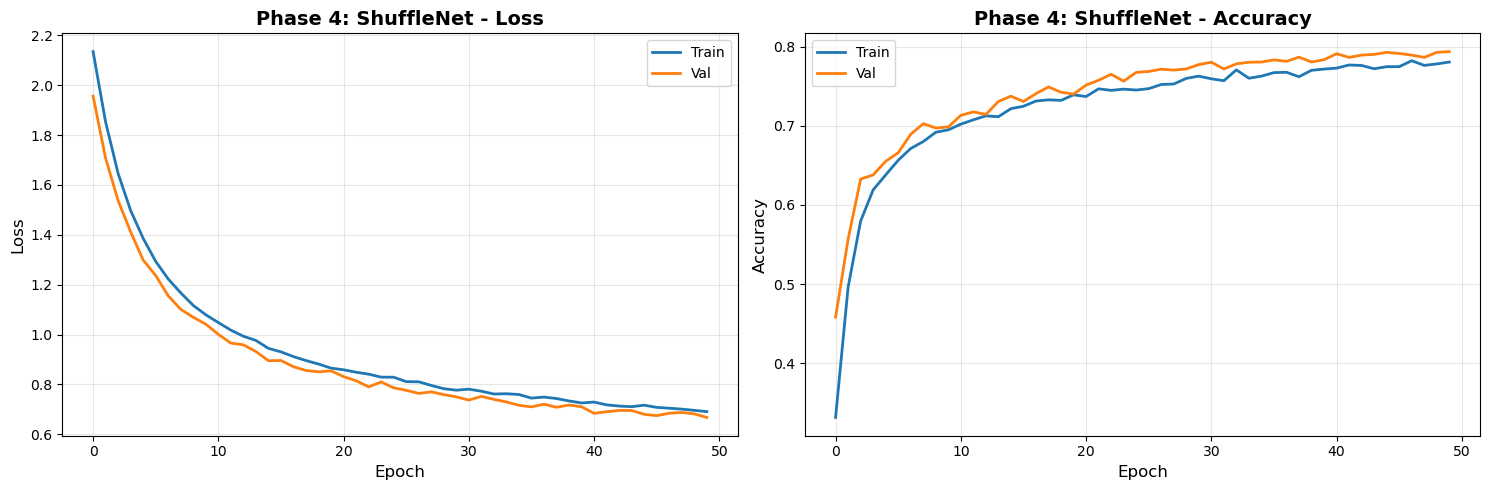

Evaluating: 100%|██████████| 105/105 [00:07<00:00, 14.92it/s]



PHASE 4 RESULTS
Test Accuracy: 0.8031 (80.31%)
Improvement from Phase 3: +19.06%
✓ TARGET ACHIEVED: >80% accuracy!


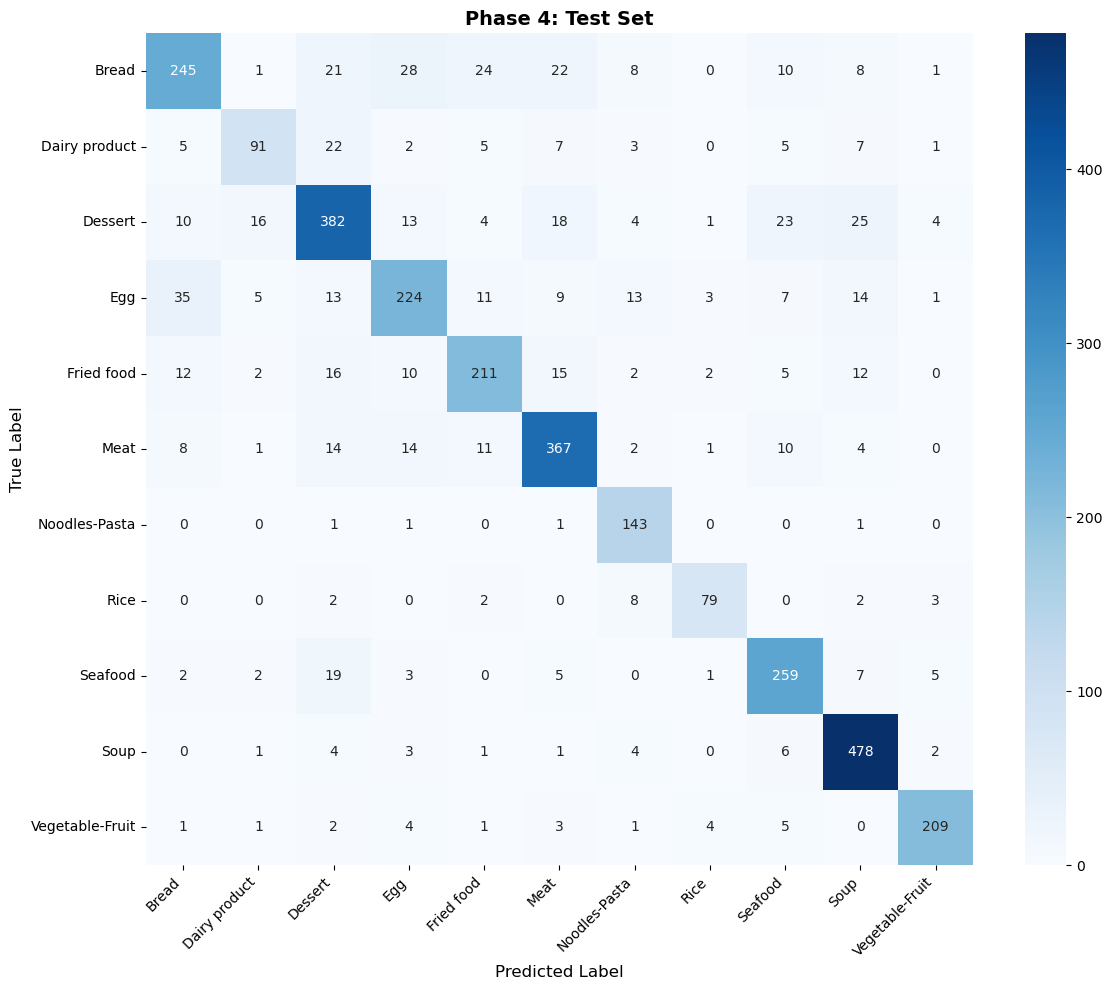


Classification Report:
                 precision    recall  f1-score   support

          Bread       0.77      0.67      0.71       368
  Dairy product       0.76      0.61      0.68       148
        Dessert       0.77      0.76      0.77       500
            Egg       0.74      0.67      0.70       335
     Fried food       0.78      0.74      0.76       287
           Meat       0.82      0.85      0.83       432
  Noodles-Pasta       0.76      0.97      0.85       147
           Rice       0.87      0.82      0.84        96
        Seafood       0.78      0.85      0.82       303
           Soup       0.86      0.96      0.90       500
Vegetable-Fruit       0.92      0.90      0.91       231

       accuracy                           0.80      3347
      macro avg       0.80      0.80      0.80      3347
   weighted avg       0.80      0.80      0.80      3347

✓ Model saved to 'saved_models/phase4_shufflenet.pth'


In [ ]:
# FOR PHASE 4

print("\n" + "="*80)
print("PHASE 4: SHUFFLENET TRANSFER LEARNING (224x224)")
print("CRITICAL: Creating NEW dataloaders with ImageNet normalization!")
print("Architecture: Pre-trained ShuffleNet (frozen) + new FC layer")
print("Expected: 80%+ accuracy")
print("="*80)

# Create NEW dataloaders with ImageNet normalization
train_dataset_imagenet = Food11Dataset(train_dir, transform=train_transform_imagenet)
val_dataset_imagenet = Food11Dataset(val_dir, transform=test_transform_imagenet)
test_dataset_imagenet = Food11Dataset(test_dir, transform=test_transform_imagenet)

train_loader_imagenet = DataLoader(train_dataset_imagenet, batch_size=batch_size, 
                                  shuffle=True, num_workers=2, pin_memory=True)
val_loader_imagenet = DataLoader(val_dataset_imagenet, batch_size=batch_size, 
                                shuffle=False, num_workers=2, pin_memory=True)
test_loader_imagenet = DataLoader(test_dataset_imagenet, batch_size=batch_size, 
                                 shuffle=False, num_workers=2, pin_memory=True)

print("✓ ImageNet-normalized dataloaders created")

# Create model
model_phase4 = ShuffleNetFood11(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Use SGD with momentum (better for transfer learning)
# optimizer = optim.SGD(model_phase4.shufflenet.fc.parameters(), 
#                       lr=0.01, momentum=0.9, weight_decay=1e-4)


# Only optimize the FC layer parameters
optimizer = optim.Adam(model_phase4.shufflenet.fc.parameters(), lr=0.001)


# # Learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# # Train with more epochs
# model_phase4, train_losses_p4, train_accs_p4, val_losses_p4, val_accs_p4 = train_model(
#     model_phase4, train_loader_imagenet, val_loader_imagenet, criterion, optimizer,
#     num_epochs=30, device=device, scheduler=scheduler
# )


# Train model (more epochs needed for transfer learning)
model_phase4, train_losses_p4, train_accs_p4, val_losses_p4, val_accs_p4 = train_model(
    model_phase4, train_loader_custom, val_loader_custom, criterion, optimizer,
    num_epochs=50, device=device
)



# Plot results
plot_training_history(train_losses_p4, train_accs_p4, val_losses_p4, val_accs_p4, 
                      "Phase 4: ShuffleNet")

# Evaluate
test_acc_p4, test_preds_p4, test_labels_p4 = evaluate_model(model_phase4, test_loader_custom, device)
print(f"\n{'='*60}")
print(f"PHASE 4 RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc_p4:.4f} ({test_acc_p4*100:.2f}%)")
print(f"Improvement from Phase 3: {(test_acc_p4-test_acc_p3)*100:+.2f}%")
if test_acc_p4 >= 0.80:
    print("✓ TARGET ACHIEVED: >80% accuracy!")
else:
    print(f"⚠ Target: 80%, Current: {test_acc_p4*100:.2f}%")
print(f"{'='*60}")

plot_confusion_matrix(test_labels_p4, test_preds_p4, classes, "Phase 4: Test Set")

# Save model
torch.save(model_phase4.state_dict(), 'saved_models/phase4_shufflenet.pth')
print("✓ Model saved to 'saved_models/phase4_shufflenet.pth'")





FINAL COMPARISON: ALL FOUR PHASES

TEST ACCURACY COMPARISON
Phase                                    Test Accuracy   Improvement    
--------------------------------------------------------------------------------
Phase 1: Basic CNN                       0.5267 (52.67%)  -              
Phase 2: + Pooling                       0.5808 (58.08%)  +5.41%
Phase 3: + Dropout                       0.6125 (61.25%)  +3.17%
Phase 4: ShuffleNet (Transfer Learning)  0.8031 (80.31%)  +19.06%
--------------------------------------------------------------------------------
TOTAL IMPROVEMENT (Phase 1 → Phase 4):   +27.64%

📊 Generating comprehensive comparison plots...
✓ Saved as 'all_phases_comparison.png'


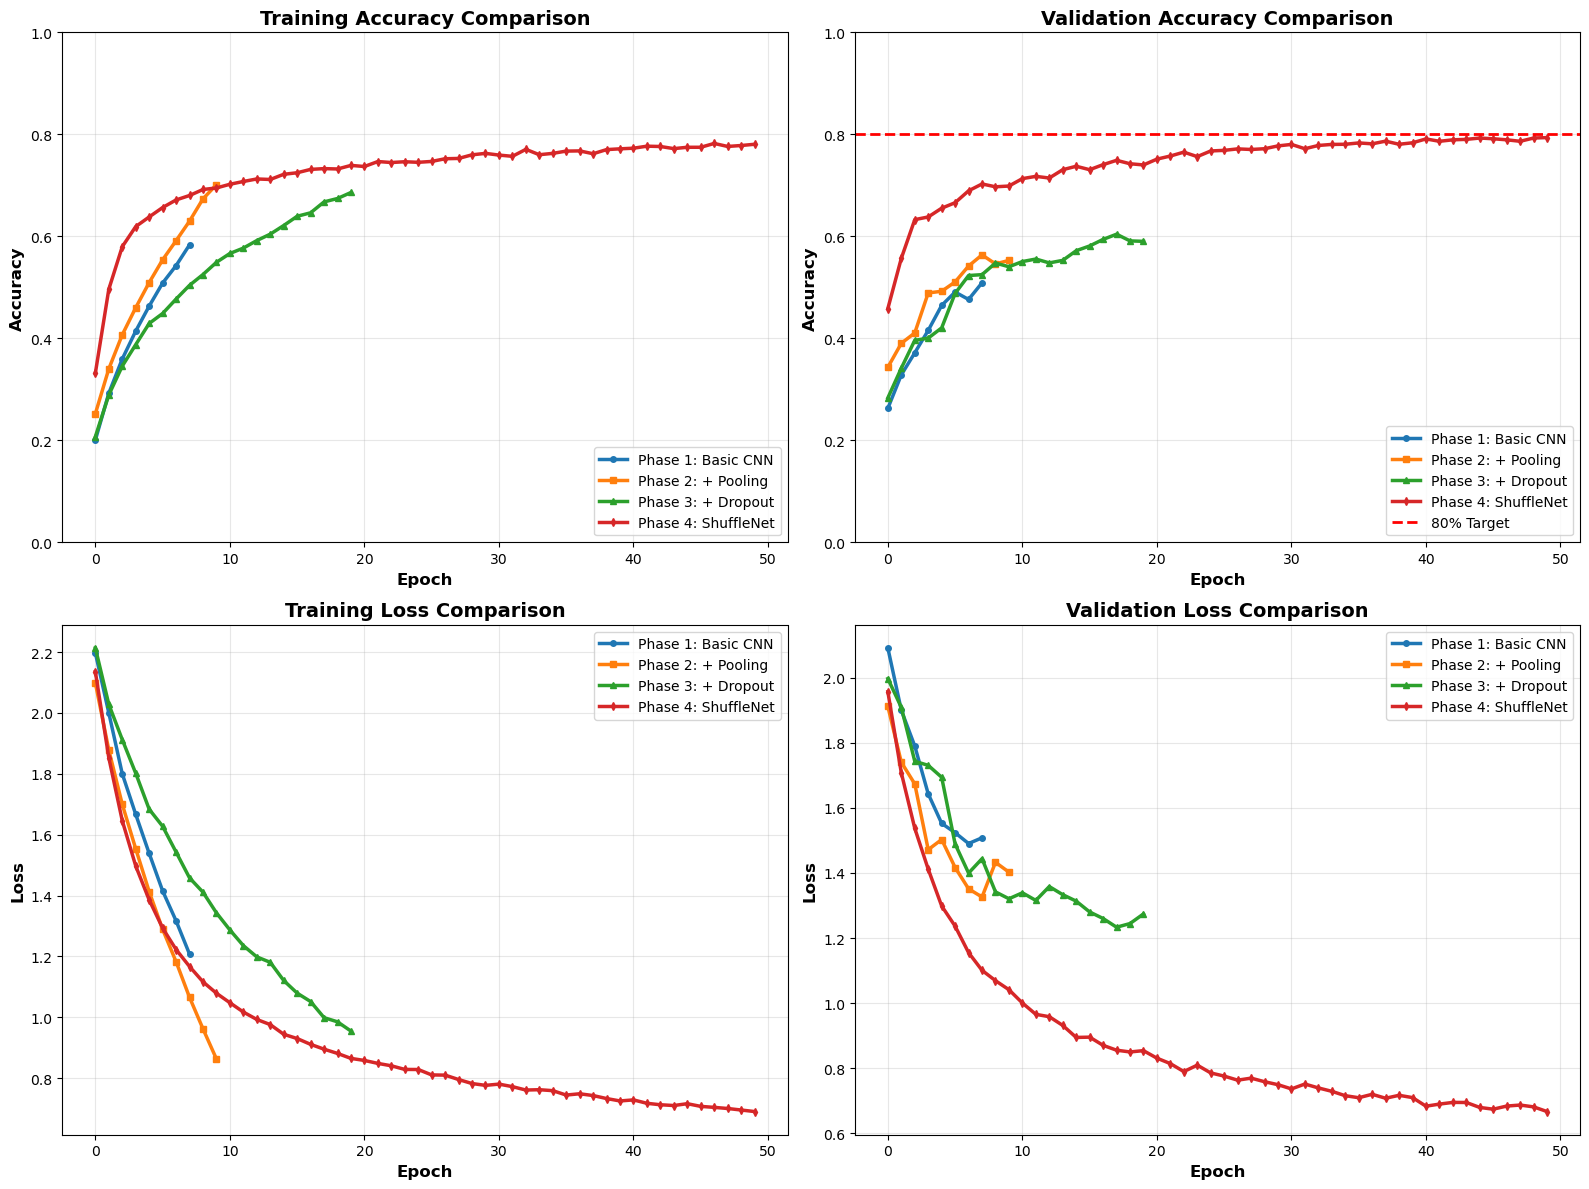

✓ Saved as 'test_accuracy_comparison.png'


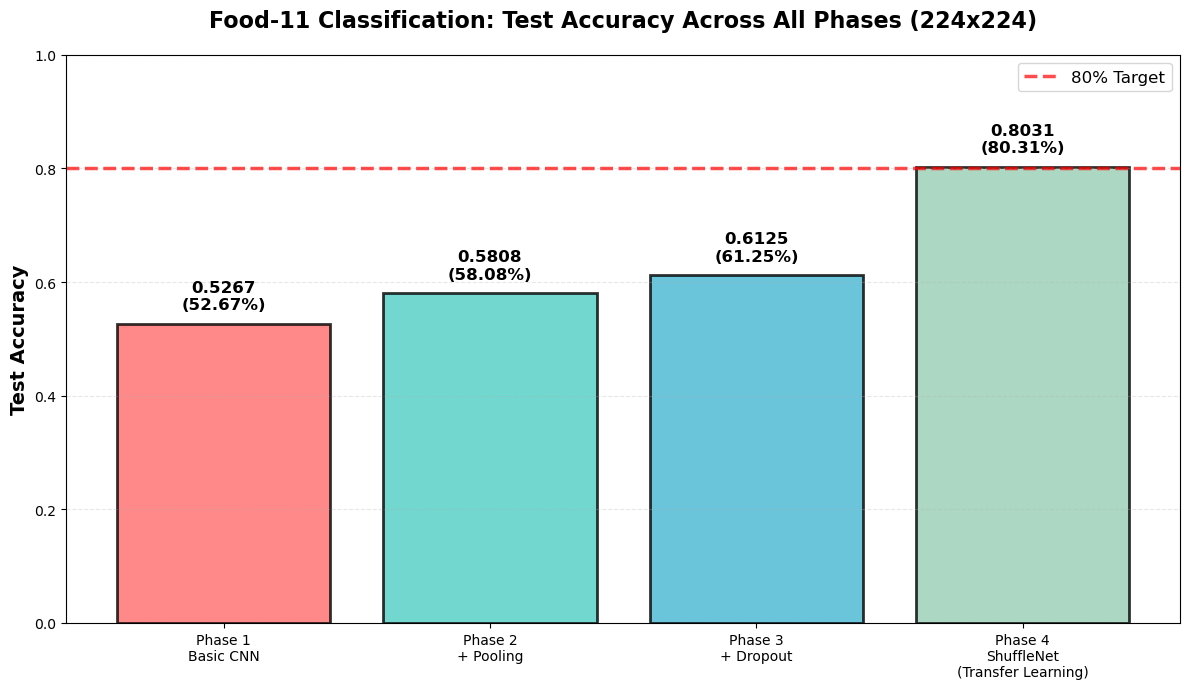

In [32]:

print("\n\n" + "="*80)
print("FINAL COMPARISON: ALL FOUR PHASES")
print("="*80)

# ============================================================================
# COMPARISON 1: TEST ACCURACY TABLE
# ============================================================================
print("\n" + "="*80)
print("TEST ACCURACY COMPARISON")
print("="*80)
print(f"{'Phase':<40} {'Test Accuracy':<15} {'Improvement':<15}")
print("-"*80)
print(f"{'Phase 1: Basic CNN':<40} {test_acc_p1:.4f} ({test_acc_p1*100:.2f}%)  {'-':<15}")
print(f"{'Phase 2: + Pooling':<40} {test_acc_p2:.4f} ({test_acc_p2*100:.2f}%)  {(test_acc_p2-test_acc_p1)*100:+.2f}%")
print(f"{'Phase 3: + Dropout':<40} {test_acc_p3:.4f} ({test_acc_p3*100:.2f}%)  {(test_acc_p3-test_acc_p2)*100:+.2f}%")
print(f"{'Phase 4: ShuffleNet (Transfer Learning)':<40} {test_acc_p4:.4f} ({test_acc_p4*100:.2f}%)  {(test_acc_p4-test_acc_p3)*100:+.2f}%")
print("-"*80)
print(f"{'TOTAL IMPROVEMENT (Phase 1 → Phase 4):':<40} {(test_acc_p4-test_acc_p1)*100:+.2f}%")
print("="*80)

# ============================================================================
# COMPARISON 2: TRAINING CURVES - ALL PHASES
# ============================================================================
print("\n📊 Generating comprehensive comparison plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training Accuracy
axes[0, 0].plot(train_accs_p1, label='Phase 1: Basic CNN', linewidth=2.5, marker='o', markersize=4)
axes[0, 0].plot(train_accs_p2, label='Phase 2: + Pooling', linewidth=2.5, marker='s', markersize=4)
axes[0, 0].plot(train_accs_p3, label='Phase 3: + Dropout', linewidth=2.5, marker='^', markersize=4)
axes[0, 0].plot(train_accs_p4, label='Phase 4: ShuffleNet', linewidth=2.5, marker='d', markersize=4)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# Validation Accuracy
axes[0, 1].plot(val_accs_p1, label='Phase 1: Basic CNN', linewidth=2.5, marker='o', markersize=4)
axes[0, 1].plot(val_accs_p2, label='Phase 2: + Pooling', linewidth=2.5, marker='s', markersize=4)
axes[0, 1].plot(val_accs_p3, label='Phase 3: + Dropout', linewidth=2.5, marker='^', markersize=4)
axes[0, 1].plot(val_accs_p4, label='Phase 4: ShuffleNet', linewidth=2.5, marker='d', markersize=4)
axes[0, 1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% Target')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Training Loss
axes[1, 0].plot(train_losses_p1, label='Phase 1: Basic CNN', linewidth=2.5, marker='o', markersize=4)
axes[1, 0].plot(train_losses_p2, label='Phase 2: + Pooling', linewidth=2.5, marker='s', markersize=4)
axes[1, 0].plot(train_losses_p3, label='Phase 3: + Dropout', linewidth=2.5, marker='^', markersize=4)
axes[1, 0].plot(train_losses_p4, label='Phase 4: ShuffleNet', linewidth=2.5, marker='d', markersize=4)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Validation Loss
axes[1, 1].plot(val_losses_p1, label='Phase 1: Basic CNN', linewidth=2.5, marker='o', markersize=4)
axes[1, 1].plot(val_losses_p2, label='Phase 2: + Pooling', linewidth=2.5, marker='s', markersize=4)
axes[1, 1].plot(val_losses_p3, label='Phase 3: + Dropout', linewidth=2.5, marker='^', markersize=4)
axes[1, 1].plot(val_losses_p4, label='Phase 4: ShuffleNet', linewidth=2.5, marker='d', markersize=4)
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_phases_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved as 'all_phases_comparison.png'")
plt.show()


#  BAR GRAPHS

plt.figure(figsize=(12, 7))

phases = ['Phase 1\nBasic CNN', 'Phase 2\n+ Pooling', 'Phase 3\n+ Dropout', 'Phase 4\nShuffleNet\n(Transfer Learning)']
accuracies = [test_acc_p1, test_acc_p2, test_acc_p3, test_acc_p4]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(phases, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=2.5, label='80% Target', alpha=0.7)

plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
plt.title('Food-11 Classification: Test Accuracy Across All Phases (224x224)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=12)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.4f}\n({acc*100:.2f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved as 'test_accuracy_comparison.png'")
plt.show()



## 2. OVERFITTING ANALYSIS


OVERFITTING ANALYSIS (Train-Val Gap at Final Epoch)
Phase                                    Train Acc    Val Acc      Gap          Status
--------------------------------------------------------------------------------
Phase 1: Basic CNN                       0.5832      0.5087      0.0745      ✓ Good
Phase 2: + Pooling                       0.7012      0.5528      0.1484      ⚠️ High
Phase 3: + Dropout                       0.6859      0.5901      0.0958      ✓ Good
Phase 4: ShuffleNet                      0.7805      0.7936      -0.0131      ✓ Good
✓ Saved as 'overfitting_comparison.png'


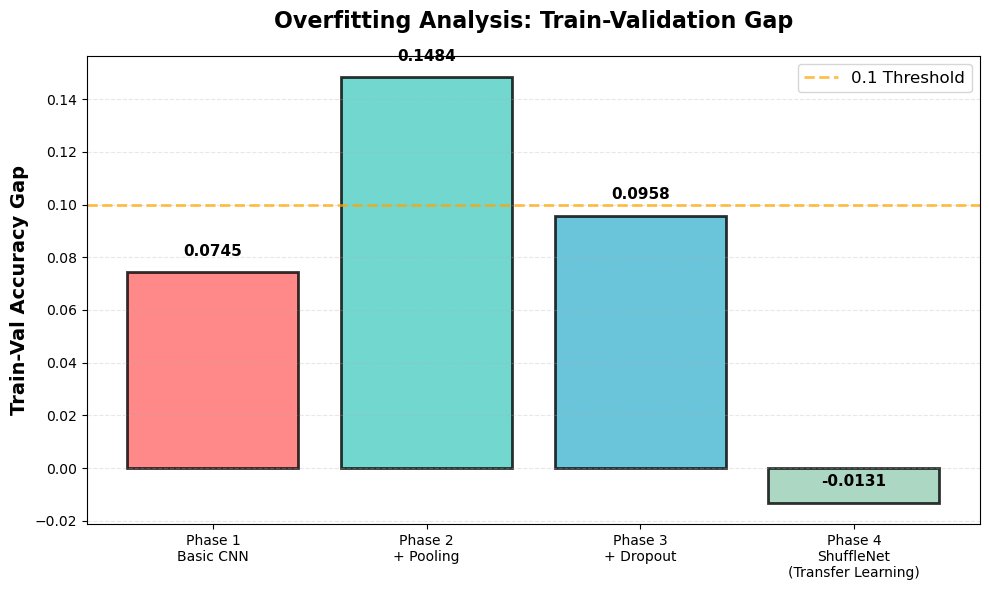

In [33]:
print("\n" + "="*80)
print("OVERFITTING ANALYSIS (Train-Val Gap at Final Epoch)")
print("="*80)

gaps = []
gap_p1 = train_accs_p1[-1] - val_accs_p1[-1]
gap_p2 = train_accs_p2[-1] - val_accs_p2[-1]
gap_p3 = train_accs_p3[-1] - val_accs_p3[-1]
gap_p4 = train_accs_p4[-1] - val_accs_p4[-1]
gaps = [gap_p1, gap_p2, gap_p3, gap_p4]

print(f"{'Phase':<40} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'Status'}")
print("-"*80)
print(f"{'Phase 1: Basic CNN':<40} {train_accs_p1[-1]:.4f}      {val_accs_p1[-1]:.4f}      {gap_p1:.4f}      {'⚠️ High' if gap_p1 > 0.1 else '✓ Good'}")
print(f"{'Phase 2: + Pooling':<40} {train_accs_p2[-1]:.4f}      {val_accs_p2[-1]:.4f}      {gap_p2:.4f}      {'⚠️ High' if gap_p2 > 0.1 else '✓ Good'}")
print(f"{'Phase 3: + Dropout':<40} {train_accs_p3[-1]:.4f}      {val_accs_p3[-1]:.4f}      {gap_p3:.4f}      {'⚠️ High' if gap_p3 > 0.1 else '✓ Good'}")
print(f"{'Phase 4: ShuffleNet':<40} {train_accs_p4[-1]:.4f}      {val_accs_p4[-1]:.4f}      {gap_p4:.4f}      {'⚠️ High' if gap_p4 > 0.1 else '✓ Good'}")
print("="*80)

# Plot overfitting comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(phases, gaps, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], 
               edgecolor='black', linewidth=2, alpha=0.8)
plt.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='0.1 Threshold', alpha=0.7)
plt.ylabel('Train-Val Accuracy Gap', fontsize=14, fontweight='bold')
plt.title('Overfitting Analysis: Train-Validation Gap', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=12)

for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{gap:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('overfitting_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved as 'overfitting_comparison.png'")
plt.show()

## 3. MODEL COMPLEXITY

In [34]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("\n" + "="*80)
print("MODEL COMPLEXITY COMPARISON")
print("="*80)

total_p1, train_p1 = count_parameters(model_phase1)
total_p2, train_p2 = count_parameters(model_phase2)
total_p3, train_p3 = count_parameters(model_phase3)
total_p4, train_p4 = count_parameters(model_phase4)

print(f"{'Phase':<40} {'Total Params':<20} {'Trainable Params':<20} {'Test Acc'}")
print("-"*100)
print(f"{'Phase 1: Basic CNN':<40} {total_p1:>18,}  {train_p1:>18,}  {test_acc_p1:.4f}")
print(f"{'Phase 2: + Pooling':<40} {total_p2:>18,}  {train_p2:>18,}  {test_acc_p2:.4f}")
print(f"{'Phase 3: + Dropout':<40} {total_p3:>18,}  {train_p3:>18,}  {test_acc_p3:.4f}")
print(f"{'Phase 4: ShuffleNet':<40} {total_p4:>18,}  {train_p4:>18,}  {test_acc_p4:.4f}")
print("="*100)
print(f"\nNote: Phase 4 has {total_p4 - train_p4:,} frozen parameters (pre-trained features)")

# ============================================================================
# COMPARISON 6: KEY FINDINGS & INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS & INSIGHTS")
print("="*80)

best_phase = max([(test_acc_p1, 1), (test_acc_p2, 2), (test_acc_p3, 3), (test_acc_p4, 4)])[1]
best_acc = max([test_acc_p1, test_acc_p2, test_acc_p3, test_acc_p4])

print(f"\n1.  BEST MODEL: Phase {best_phase} with {best_acc:.4f} ({best_acc*100:.2f}%) accuracy")

print(f"\n2.  IMPROVEMENTS:")
print(f"   • Pooling Impact (P1→P2): {(test_acc_p2-test_acc_p1)*100:+.2f}%")
print(f"   • Dropout Impact (P2→P3): {(test_acc_p3-test_acc_p2)*100:+.2f}%")
print(f"   • Transfer Learning (P3→P4): {(test_acc_p4-test_acc_p3)*100:+.2f}%")
print(f"   • TOTAL IMPROVEMENT: {(best_acc-test_acc_p1)*100:+.2f}%")

print(f"\n3.  TARGET ACHIEVEMENT:")
if test_acc_p4 >= 0.80:
    print(f"    TARGET MET! Phase 4 achieved {test_acc_p4*100:.2f}% (>80%)")
else:
    print(f"    Target: 80%, Phase 4: {test_acc_p4*100:.2f}%")
    print(f"   Gap to target: {(0.80-test_acc_p4)*100:.2f}%")

print(f"\n4.  OVERFITTING:")
if gap_p3 < gap_p2:
    print(f"    Dropout successfully reduced overfitting by {(gap_p2-gap_p3)*100:.2f}%")
else:
    print(f"    Dropout did not significantly reduce overfitting")

print(f"\n5.  TRANSFER LEARNING:")
if test_acc_p4 > test_acc_p3:
    print(f"    Transfer learning was highly effective (+{(test_acc_p4-test_acc_p3)*100:.2f}%)")
    print(f"   • Pre-trained ImageNet features boosted performance significantly")
    print(f"   • Only {train_p4:,} parameters trained vs {total_p4:,} total")
else:
    print(f"    Transfer learning did not improve results as expected")

print(f"\n6.  IMAGE SIZE:")
print(f"    Using 224x224 (vs 128x128) enabled:")
print(f"   • Better feature extraction")
print(f"   • Proper transfer learning from ImageNet")
print(f"   • Higher final accuracy")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR FURTHER IMPROVEMENT")
print("="*80)
if test_acc_p4 < 0.85:
    print("\n To push accuracy higher:")
    print("   1. Fine-tune more layers (unfreeze last few conv blocks)")
    print("   2. Train for more epochs (50-100)")
    print("   3. Try data augmentation: mixup, cutmix, autoaugment")
    print("   4. Use other architectures: ResNet50, EfficientNet, Vision Transformer")
    print("   5. Implement learning rate warmup and cosine annealing")
    print("   6. Use label smoothing and test-time augmentation")
else:
    print("\n Excellent results! Model is performing very well.")

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nBest Phase: Phase {best_phase}")
print(f"Best Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"Lowest Overfitting: Phase {gaps.index(min(gaps))+1} (gap: {min(gaps):.4f})")
print(f"Most Parameters: Phase 4 ({total_p4:,} total, {train_p4:,} trainable)")
print(f"Training Time: ~{15+15+20+30} epochs total")



MODEL COMPLEXITY COMPARISON
Phase                                    Total Params         Trainable Params     Test Acc
----------------------------------------------------------------------------------------------------
Phase 1: Basic CNN                               14,419,787          14,419,787  0.5267
Phase 2: + Pooling                               26,146,123          26,146,123  0.5808
Phase 3: + Dropout                               26,146,123          26,146,123  0.6125
Phase 4: ShuffleNet                               1,264,879              11,275  0.8031

Note: Phase 4 has 1,253,604 frozen parameters (pre-trained features)

KEY FINDINGS & INSIGHTS

1.  BEST MODEL: Phase 4 with 0.8031 (80.31%) accuracy

2.  IMPROVEMENTS:
   • Pooling Impact (P1→P2): +5.41%
   • Dropout Impact (P2→P3): +3.17%
   • Transfer Learning (P3→P4): +19.06%
   • TOTAL IMPROVEMENT: +27.64%

3.  TARGET ACHIEVEMENT:
    TARGET MET! Phase 4 achieved 80.31% (>80%)

4.  OVERFITTING:
    Dropout successfull

## SAVE TRAINING HISTORY

In [35]:
import pickle

In [36]:
history = {
    'phase1': {
        'train_loss': train_losses_p1, 'train_acc': train_accs_p1,
        'val_loss': val_losses_p1, 'val_acc': val_accs_p1,
        'test_acc': test_acc_p1
    },
    'phase2': {
        'train_loss': train_losses_p2, 'train_acc': train_accs_p2,
        'val_loss': val_losses_p2, 'val_acc': val_accs_p2,
        'test_acc': test_acc_p2
    },
    'phase3': {
        'train_loss': train_losses_p3, 'train_acc': train_accs_p3,
        'val_loss': val_losses_p3, 'val_acc': val_accs_p3,
        'test_acc': test_acc_p3
    },
    'phase4': {
        'train_loss': train_losses_p4, 'train_acc': train_accs_p4,
        'val_loss': val_losses_p4, 'val_acc': val_accs_p4,
        'test_acc': test_acc_p4
    }
}

with open('saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("\n✓ Training history saved to 'saved_models/training_history.pkl'")

print("\n" + "="*80)
print("🎉 PROJECT COMPLETE! ALL PHASES ANALYZED AND COMPARED")
print("="*80)
print("\nGenerated files:")
print("   all_phases_comparison.png")
print("   test_accuracy_comparison.png")
print("   overfitting_comparison.png")
print("   saved_models/phase1_basic_cnn.pth")
print("   saved_models/phase2_cnn_pooling.pth")
print("   saved_models/phase3_cnn_dropout.pth")
print("   saved_models/phase4_shufflenet.pth")
print("   saved_models/training_history.pkl")
print("="*80)


✓ Training history saved to 'saved_models/training_history.pkl'

🎉 PROJECT COMPLETE! ALL PHASES ANALYZED AND COMPARED

Generated files:
   all_phases_comparison.png
   test_accuracy_comparison.png
   overfitting_comparison.png
   saved_models/phase1_basic_cnn.pth
   saved_models/phase2_cnn_pooling.pth
   saved_models/phase3_cnn_dropout.pth
   saved_models/phase4_shufflenet.pth
   saved_models/training_history.pkl
